In [1]:
import sys
import PyQt5
from PyQt5 import QtGui
from PyQt5.QtWidgets import  QApplication, QWidget, QPushButton, QVBoxLayout, QMessageBox, QLineEdit, QFormLayout,QLabel, QGridLayout, QCheckBox, QSlider
from PyQt5.QtCore import Qt, QTimer, QObject, QThread, pyqtSignal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
import scipy.stats as stats
from time import time, sleep


In [3]:

from Stage import Stage
import CamHamPy

In [4]:
class CameraSettings:
    Gain=1
    Exposure=500
    EMCCD=False

Try me
#These are fake objects that have the same interfaces as the camera and stage objects

class DummyCamera:
    def Snap(self, Exposure, GainMode, Gain):
        return(Gain*Exposure*np.random.rand(512,512))
    
class DummyStage: 
    X=None
    Y=None
    Z=None


    def MoveToX(self,x):
        self.X=x

    def MoveToY(self,y):
        self.Y=y

    def MoveToZ(self,z):
        self.Z=z

    def MoveTo(self,x,y,z):
        self.MoveToX(x)
        self.MoveToY(y)
        self.MoveToZ(z)

        
class ImageStream(QObject):

    image=pyqtSignal(np.ndarray)
    stats=pyqtSignal(list)
    finished=pyqtSignal()
    CS=CameraSettings()

    MyCamera=None
    
    def __init__(self,camdict):
        super().__init__()
        self.MyCamera=camdict
    
    def run(self):
        while(True):
            if(self.MyCamera['go']==True):
                myimage = np.array(self.MyCamera['cam'].Snap(self.MyCamera['CS'].Exposure/1000, int(self.MyCamera['CS'].EMCCD), self.MyCamera['CS'].Gain))
                self.image.emit(myimage)

                mystats = [sum(sum(myimage)),
                        stats.kurtosis(np.ndarray.flatten(myimage))]
                self.stats.emit(mystats)
            sleep(self.MyCamera['CS'].Exposure/1000)


            

In [5]:

class FieldSettings:
    XMin=-5
    XMax=5
    XStep=0.05

    YMin=-5
    YMax=5
    YStep=0.05

    ZMin=3.5
    ZMax=4.2
    ZStep=0.001
    
    XInit=1
    YInit=1
    ZInit=3.7
    
    ZSweepMin=3.7
    ZSweepMax=4.1
    ZSweepSteps=40

class History:
    X=[]
    Y=[]
    Z=[]
    Intensity=[]
    Kurtosis=[]
    Time=[]

In [6]:
'''Move the stage'''

class MicroGui:

 
    #Hooks to hardware:
    
    
    #By putting this in a dictionary it allows us to pass by ref to
    # other threads.
    camdict={'cam':DummyCamera(),
            'CS':CameraSettings(),
            'go':False}
    
    MyStage=DummyStage()
    
    def SetStage(self,X,Y,Z):
        self.MyStage.MoveTo(X,Y,Z)

    def SetupCameraThread(self):
        self.thread = QThread()
        self.worker=ImageStream(self.camdict)
        self.worker.moveToThread(self.thread)
        self.thread.started.connect(self.worker.run)
        self.worker.image.connect(self.updateimage)
        self.worker.stats.connect(self.updatestats)
        self.thread.start()
    
    def updateimage(self,image):
        self.CurrentImage=image
        self.LastSnapTime=time()
        self.MakePhoto()


    def updatestats(self, stats):
        self.His.Intensity.append(stats[0])
        self.His.Kurtosis.append(stats[1])
        self.His.Z.append(self.Z)
        self.His.Time.append(self.LastSnapTime)  
        self.ZBestKurtosis=self.His.Z[np.argmax(self.His.Kurtosis)]
        self.ZBestIntensity=self.His.Z[np.argmax(self.His.Intensity)]
        if(self.AmStreaming==False):
            self.camdict['go']=False
        
        self.MakePosPlots()
            
        self.NextStageAction()
        self.NextCameraAction()

            
    def EnableCamera(self):
        self.camdict['cam']=CamHamPy.CamHamPy()

        
    def DisableCamera(self):
        self.camdict['cam'].close()
        self.camdict['cam']=DummyCamera()
    
    def EnableStage(self):
        self.MyStage=Stage(LastPos=False)
        self.MyStage.MoveTo(self.X,self.Y,self.Z)
        

    #Internal variables

    His= History()
    CS = CameraSettings()
    FS = FieldSettings()
    
    AmZSweeping=False
    AmStreaming=False
    ServosOn=True
    
    CurrentImage=np.array([[0,0],[0,0]])
    
    def ClearZHistory(self):
        self.His.Z=[]
        self.His.Intensity=[]
        self.His.Kurtosis=[]
        self.His.Time=[]

   
        
    #QT Widget functions 
    def on_stream_click(self):
        if(self.AmStreaming==False):
            self.AmStreaming=True
            self.Stream.setText("Stop Stream")
            self.camdict['go']=True
        else:
            self.Stream.setText("Stream")
            self.AmStreaming=False
            self.camdict['go']=False
        
    def on_one_click(self):
        AmStreaming=False
        self.camdict['go']=True

    def on_slider_move(self):
        self.MoveTo(self.FS.XMin+self.XSlide.value()*self.FS.XStep,
                    self.FS.YMin+self.YSlide.value()*self.FS.YStep,
                    self.FS.ZMin+self.ZSlide.value()*self.FS.ZStep)
        
    def on_textbox_edit(self):
        self.MoveTo(float(self.XText.text()),
                    float(self.YText.text()),
                    float(self.ZText.text()))
        
    def on_zsweep_click(self):
        if(self.AmZSweeping==False):
            self.MoveTo(self.X,self.Y,float(self.ZSweepMin.text()))
            self.NextStageAction=self.ZSweepStageAction
            self.FS.ZSweepMin=float(self.ZSweepMin.text())
            self.FS.ZSweepMax=float(self.ZSweepMax.text())
            self.FS.ZSweepSteps=float(self.ZSweepSteps.text())
            self.ZSweep.setText("Stop ZSweep")
            self.AmZSweeping=True
        else:
            self.NextStageAction=self.NullStageAction
            self.ZSweep.setText("ZSweep")
            self.AmZSweeping=False
        
    def on_cam_settings_change(self):
        self.camdict['CS'].EMCCD=self.CamEMCCD.isChecked()
        #try:    
        if(self.camdict['CS'].EMCCD==True):
            if(int(self.CamExposure.text())<27):
                self.camdict['CS'].Exposure=27
            elif(int(self.CamExposure.text())>10000):
                self.camdict['CS'].Exposure=10000
            else:
                try:
                    self.camdict['CS'].Exposure=int(self.CamExposure.text())
                except:
                    self.camdict['CS'].Exposure=500
        elif(self.camdict['CS'].EMCCD==False):
            if(int(self.CamExposure.text())<500):
                self.camdict['CS'].Exposure=500
            elif(int(self.CamExposure.text())>10000):
                self.camdict['CS'].Exposure=10000
            else:
                self.camdict['CS'].Exposure=int(self.CamExposure.text())

            
        #try:
        if(self.camdict['CS'].EMCCD==False):
            self.camdict['CS'].Gain=1
        else:
            if(int(self.CamGain.text())<1):
                self.camdict['CS'].Gain=1
            elif(int(self.CamGain.text())>255):
                self.camdict['CS'].Gain=255
            else:
                self.camdict['CS'].Gain=int(self.CamGain.text())     
            
        self.CamExposure.setText(str(self.camdict['CS'].Exposure))
        self.CamGain.setText(str(self.camdict['CS'].Gain))
                
    def on_servo_change(self):
        if(self.ServosCheckBox.isChecked()==True):
            self.MyStage.EnableServos()
        elif(self.ServosCheckBox.isChecked()==False):
            self.MyStage.DisableServos()
            
    def on_camera_change(self):
        if(self.CameraCheckBox.isChecked()==True):
            self.EnableCamera()
        elif(self.CameraCheckBox.isChecked()==False):
            self.DisableCamera()
            
            
    def on_autointensity(self):
        self.MoveTo(self.X,self.Y,self.ZBestIntensity)
        
    def on_autokurtosis(self):
        self.MoveTo(self.X,self.Y,self.ZBestKurtosis)
        
    def on_sequence_go(self):
        if(self.Sequence.text()=="Go"):
            if(self.AmStreaming==False):
                self.on_stream_click()
            self.ImagesToSave=int(self.StoreCount.text())
            self.NextCameraAction=self.SequenceCameraAction
            self.Sequence.setText("Stop")
        else:
            self.StoreCount.setText(str(self.ImagesToSave))
            self.NextCameraAction=self.NullCameraAction
            self.Sequence.setText("Go")
    
    def NullCameraAction(self):
        return
    
    def SequenceCameraAction(self):
        ImageID=int(self.StoreCount.text())
        if(ImageID>1):
            self.StoreCount.setText(str(ImageID-1))
            np.savetxt(self.StorePath.text()+"/im_" +str(self.ImagesToSave-ImageID)+".txt", self.CurrentImage)
        else:
            self.NextCameraAction=self.NullCameraAction
            self.Sequence.setText("Go")
            
    def NullStageAction(self):
        return
    
    def ZSweepStageAction(self):
        if(self.Z<self.FS.ZSweepMax):
            self.MoveTo(self.X,self.Y,self.Z+(self.FS.ZSweepMax-self.FS.ZSweepMin)/self.FS.ZSweepSteps)
        else:
            NextStageAction=self.NullStageAction
            self.AmZSweeping=False
            self.ZSweep.setText("ZSweep")
                
    def MoveTo(self, X,Y,Z):
        if(self.ServosOn):
            self.X=round(X,6)
            self.Y=round(Y,6)
            self.Z=round(Z,6)
        else:
            dlg = QDialog(self)
            dlg.setWindowTitle("Servos are off")
            dlg.setText("CANNOT MOVE WITH SERVOS OFF!")
            dlg.exec()
        self.UpdateAll()
        
    def UpdateAll(self):   
        self.XText.setText(str(self.X))
        self.YText.setText(str(self.Y))
        self.ZText.setText(str(self.Z))
        
        self.XIs.setText(str(self.X))
        self.YIs.setText(str(self.Y))
        self.ZIs.setText(str(self.Z))
        self.XText.setText(str(self.X))
        self.YText.setText(str(self.Y))
        self.ZText.setText(str(self.Z))
        self.XSlide.setValue(int((self.X-self.FS.XMin)/self.FS.XStep))
        self.YSlide.setValue(int((self.Y-self.FS.YMin)/self.FS.YStep))
        self.ZSlide.setValue(int((self.Z-self.FS.ZMin)/self.FS.ZStep))
        
        self.SetStage(self.X,self.Y,self.Z)
        
        if((self.X!=self.His.X[-1]) or (self.Y!=self.His.Y[-1])):
            self.His.X.append(self.X)
            self.His.Y.append(self.Y)
            if(len(self.His.Z)>0):
                self.ClearZHistory()
        
    def MakePosPlots(self):
        self.ax_xy.clear()
        self.ax_z[0].clear()
        self.ax_z[1].clear()


        self.ax_xy.plot([self.X],[self.Y],'o',color='red')
        self.ax_xy.set_xlim(self.FS.XMin,self.FS.XMax)
        self.ax_xy.set_ylim(self.FS.YMin,self.FS.YMax)
        self.ax_z[0].set_xlim(self.FS.ZMin,self.FS.ZMax)
        self.ax_z[1].set_xlim(self.FS.ZMin,self.FS.ZMax)
        self.ax_z[0].set_yticks([])
        self.ax_z[1].set_yticks([])
        self.ax_z[0].set_ylabel("Intensity")
        self.ax_z[1].set_ylabel("Kurtosis")
        
        if(sum(sum(self.CurrentImage))>0):


            if(len(self.His.X)>0):
                self.ax_xy.plot(self.His.X,self.His.Y,color='dimgrey',alpha=0.1)

            if(len(self.His.Z)>0):
                self.ax_z[0].plot(self.His.Z,self.His.Intensity,'.',color='DarkGreen')
                self.ax_z[1].plot(self.His.Z,self.His.Kurtosis,'.',color='DarkBlue')
                TopIntensity=np.max(self.His.Intensity)
                TopKurtosis=np.max(self.His.Kurtosis)

                BottomIntensity=np.min(self.His.Intensity)
                BottomKurtosis=np.min(self.His.Kurtosis)


                self.ax_z[0].plot([self.ZBestIntensity,self.ZBestIntensity],[BottomIntensity,TopIntensity],':',color='pink',linewidth=1)
                self.ax_z[1].plot([self.ZBestKurtosis,self.ZBestKurtosis],[BottomKurtosis,TopKurtosis],'--',color='pink',linewidth=1)
                self.ax_z[0].plot([self.Z,self.Z],[BottomIntensity,TopIntensity],color='DarkRed',linewidth=2)
                self.ax_z[1].plot([self.Z,self.Z],[BottomKurtosis,TopKurtosis],color='DarkRed',linewidth=2)

                self.ax_z[0].set_ylim(BottomIntensity,TopIntensity)
                self.ax_z[1].set_ylim(BottomKurtosis,TopKurtosis)  

        
        self.CanvasObj.draw()
        self.CanvasObj2.draw()

    def MakePhoto(self):
        self.ax_photo.clear()
        self.ax_photo.imshow(self.CurrentImage)
        self.ax_photo.set_xticks([])
        self.ax_photo.set_yticks([])
        self.CanvasPhoto.draw()

        
        
    #GUI setups

    def SetupMoveFrame(self):
        self.MoveLayout = QGridLayout()

        self.XSlide=QSlider(orientation=Qt.Horizontal)
        self.XSlide.setRange(0, int((self.FS.XMax-self.FS.XMin)/self.FS.XStep))
        self.YSlide=QSlider(orientation=Qt.Horizontal)
        self.YSlide.setRange(0, int((self.FS.YMax-self.FS.YMin)/self.FS.YStep))
        self.ZSlide=QSlider(orientation=Qt.Horizontal)
        self.ZSlide.setRange(0, int((self.FS.ZMax-self.FS.ZMin)/self.FS.ZStep))
        
        self.XText=QLineEdit(text=str(self.FS.XInit))
        self.XText.editingFinished.connect(self.on_textbox_edit)
        self.YText=QLineEdit(text=str(self.FS.YInit))
        self.YText.editingFinished.connect(self.on_textbox_edit)
        self.ZText=QLineEdit(text=str(self.FS.ZInit))
        self.ZText.editingFinished.connect(self.on_textbox_edit)

        self.XIs=QLabel()
        self.YIs=QLabel()
        self.ZIs=QLabel()
        
        self.MoveTo(self.FS.XInit,
                  self.FS.YInit,
                  self.FS.ZInit)
        
        self.MoveLayout.addWidget(QLabel("Stage Control:"),1,0,1,3)
        self.MoveLayout.addWidget(QLabel("X"),2,0,1,1)
        self.MoveLayout.addWidget(self.XText,2,1,1,1)
        self.MoveLayout.addWidget(self.XIs,2,2,1,1)
        self.MoveLayout.addWidget(self.XSlide, 3,1,1,3)
        self.MoveLayout.addWidget(QLabel("Y"),4,0,1,1)
        self.MoveLayout.addWidget(self.YText,4,1,1,1)
        self.MoveLayout.addWidget(self.YIs,4,2,1,1)
        self.MoveLayout.addWidget(self.YSlide, 5,1,1,3)
        self.MoveLayout.addWidget(QLabel("Z"),6,0,1,1)
        self.MoveLayout.addWidget(self.ZText,6,1,1,1)
        self.MoveLayout.addWidget(self.ZIs,6,2,1,1)
        self.MoveLayout.addWidget(self.ZSlide,7,1,1,3)

        self.XSlide.sliderMoved.connect(self.on_slider_move)
        self.YSlide.sliderMoved.connect(self.on_slider_move)
        self.ZSlide.sliderMoved.connect(self.on_slider_move)     
        
    def SetupCamSettingsFrame(self):
        self.CamLayout= QFormLayout()
        self.CamLayout.addRow(QLabel("Camera Settings:"),QLabel(" "))
        self.CamGain=QLineEdit(text=str(self.camdict['CS'].Gain))
        self.CamExposure=QLineEdit(text=str(self.camdict['CS'].Exposure))
        self.CamEMCCD=QCheckBox("EMCCD")

        self.CamLayout.addRow(QLabel("Gain:"),self.CamGain)
        self.CamLayout.addRow(QLabel("Exposure:"),self.CamExposure)
        self.CamLayout.addWidget(self.CamEMCCD)

        self.CamGain.editingFinished.connect(self.on_cam_settings_change)
        self.CamExposure.editingFinished.connect(self.on_cam_settings_change)
        self.CamEMCCD.stateChanged.connect(self.on_cam_settings_change)
           
        
    def SetupActionsFrame(self):
        self.ActionsLayout= QGridLayout()
        self.ActionsLayout.addWidget(QLabel("Actions:"),1,0,1,3)
        
        
        self.ZSweep=QPushButton('ZSweep')
        self.ZSweep.clicked.connect(self.on_zsweep_click)
        self.ZSweepMin=QLineEdit(text=str(self.FS.ZSweepMin))
        self.ZSweepMax=QLineEdit(text=str(self.FS.ZSweepMax))
        self.ZSweepSteps=QLineEdit(text=str(self.FS.ZSweepSteps))
        
        self.ServosCheckBox=QCheckBox("Stage Servos:",checked=True)
        self.ServosCheckBox.stateChanged.connect(self.on_servo_change)
        
        self.CameraCheckBox=QCheckBox("Camera:",checked=True)
        self.CameraCheckBox.stateChanged.connect(self.on_camera_change)
        
        self.AutoFocusKurtosis=QPushButton("Kurtosis")
        self.AutoFocusIntensity=QPushButton("Intensity")
        self.AutoFocusKurtosis.clicked.connect(self.on_autokurtosis)
        self.AutoFocusIntensity.clicked.connect(self.on_autointensity)

        self.ActionsLayout.addWidget(self.ServosCheckBox,2,0,1,3)
        self.ActionsLayout.addWidget(self.CameraCheckBox,3,0,1,3)

        self.ActionsLayout.addWidget(self.ZSweep,5,0,1,3)
        self.ActionsLayout.addWidget(self.ZSweepMin,6,0,1,1)
        self.ActionsLayout.addWidget(self.ZSweepMax,6,1,1,1)
        self.ActionsLayout.addWidget(self.ZSweepSteps,6,2,1,1)
        
        self.ActionsLayout.addWidget(QLabel("AutoFocus:"),7,0,1,1)
        self.ActionsLayout.addWidget(self.AutoFocusIntensity,7,1,1,1)
        self.ActionsLayout.addWidget(self.AutoFocusKurtosis,7,2,1,1)
        

    def SetupCanvasFrame(self):
        self.FigLayout=QVBoxLayout()
        self.fig= plt.figure(figsize=(5,5),dpi=150)
        self.fig.add_axes(rect=[0,0,1,1])
        self.fig2= plt.figure(figsize=(5,5),dpi=150)
        self.fig2.add_axes(rect=[0,0,1,1])

        self.ax_xy=self.fig.get_axes()[0]
        gs = self.fig2.add_gridspec(2, hspace=0)
        self.ax_z = gs.subplots(sharex=True, sharey=False)
        
        self.CanvasObj=FigureCanvasQTAgg(self.fig)
        self.CanvasObj2=FigureCanvasQTAgg(self.fig2)
        self.MakePosPlots()

        self.FigLayout.addWidget(self.CanvasObj)
        self.FigLayout.addWidget(self.CanvasObj2)
        
    def SetupPhotoFrame(self):
        self.PhotoLayout=QGridLayout()
        
    
        self.photo= plt.figure(figsize=(5,5),dpi=200)
        self.photo.add_axes(rect=[0,0,1,1])
        self.ax_photo=self.photo.get_axes()[0]
        self.CanvasPhoto=FigureCanvasQTAgg(self.photo)
        self.PhotoLayout.addWidget(self.CanvasPhoto,1,0,8,4)
        
        self.Stream=QPushButton('Stream')
        self.Stream.clicked.connect(self.on_stream_click)        
        
        self.One=QPushButton('One')
        self.One.clicked.connect(self.on_one_click)        

        self.StoreCount=QLineEdit("100")
        self.StorePath=QLineEdit("./imgs/")
        self.Sequence=QPushButton("Go")
        
        self.Sequence.clicked.connect(self.on_sequence_go)
        

        self.PhotoLayout.addWidget(self.Stream,9,0,1,2)
        self.PhotoLayout.addWidget(self.One,9,2,1,2)
        
        self.PhotoLayout.addWidget(QLabel("Record sequence of:"),10,0,1,1)
        self.PhotoLayout.addWidget(self.StoreCount,11,0,1,1)
        self.PhotoLayout.addWidget(QLabel("into "),11,1,1,1)
        self.PhotoLayout.addWidget(self.StorePath,11,2,1,1)
        self.PhotoLayout.addWidget(self.Sequence,11,3,1,1)
        
    def __init__(self):

        self.LastSnapTime=time()
        self.His.X=[self.FS.XInit]
        self.His.Y=[self.FS.YInit]
        
        self.app = QApplication([])
        self.window = QWidget()
        self.layout= QGridLayout()

        self.SetupMoveFrame()
        
        self.SetupCamSettingsFrame()

        self.SetupCanvasFrame()
        
        self.SetupCameraThread()

        self.SetupActionsFrame()
        
        self.SetupPhotoFrame()
    
        self.layout.addLayout(self.MoveLayout,1,0)
        self.layout.addLayout(self.CamLayout,2,0)
        self.layout.addLayout(self.FigLayout,1,1,3,1)
        self.layout.addLayout(self.ActionsLayout,3,0)
        self.layout.addLayout(self.PhotoLayout,1,2,3,1)
        
        
        self.NextStageAction  = self.NullStageAction
        self.NextCameraAction = self.NullCameraAction
        
        self.EnableCamera()
        self.EnableStage()
        
        self.window.setLayout(self.layout)
        self.window.show()
        self.app.exec()


False
False
Dev open
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True


C:\Users\ohs2758\Anaconda3\envs\camera\lib\site-packages\ipykernel_launcher.py:285: UserWarning: Attempting to set identical bottom == top == 7385123 results in singular transformations; automatically expanding.
C:\Users\ohs2758\Anaconda3\envs\camera\lib\site-packages\ipykernel_launcher.py:286: UserWarning: Attempting to set identical bottom == top == 0.4599757438495331 results in singular transformations; automatically expanding.


True
True
True
True
True


C:\Users\ohs2758\Anaconda3\envs\camera\lib\site-packages\ipykernel_launcher.py:285: UserWarning: Attempting to set identical bottom == top == 7387703 results in singular transformations; automatically expanding.
C:\Users\ohs2758\Anaconda3\envs\camera\lib\site-packages\ipykernel_launcher.py:286: UserWarning: Attempting to set identical bottom == top == 0.49526893525572735 results in singular transformations; automatically expanding.


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


C:\Users\ohs2758\Anaconda3\envs\camera\lib\site-packages\ipykernel_launcher.py:285: UserWarning: Attempting to set identical bottom == top == 12796987 results in singular transformations; automatically expanding.
C:\Users\ohs2758\Anaconda3\envs\camera\lib\site-packages\ipykernel_launcher.py:286: UserWarning: Attempting to set identical bottom == top == 5.175369466115997 results in singular transformations; automatically expanding.


True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


False


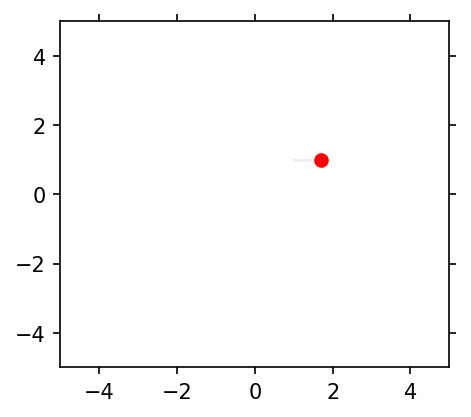

False


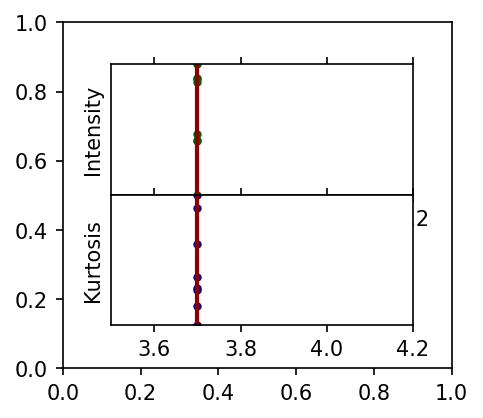

False
False
False


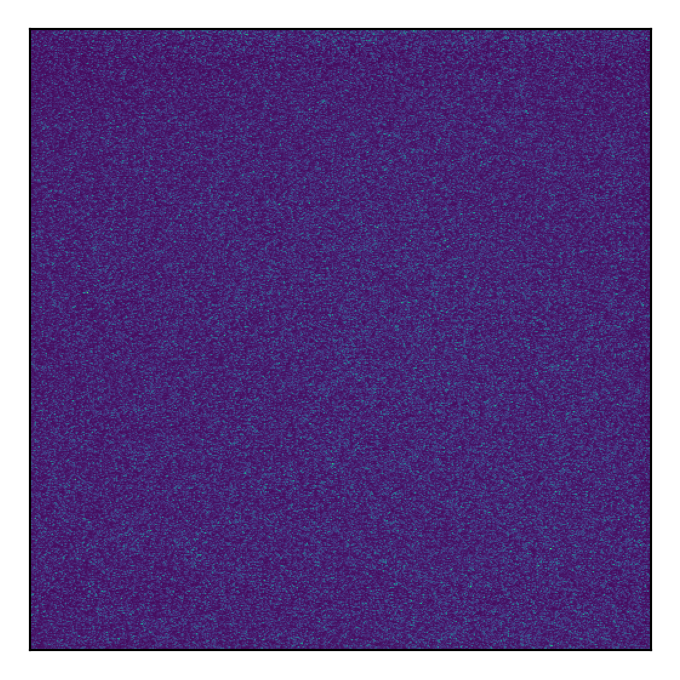

False


In [7]:
MicroGui()

In [8]:
fig=plt.figure()

<Figure size 432x288 with 0 Axes>

In [9]:
fig.add_axes()?

SyntaxError: invalid syntax (Temp/ipykernel_10680/2749086143.py, line 1)

In [ ]:
QCheckBox()?


In [ ]:
x=1+4
y=2+3

In [ ]:
x is y

In [ ]:
x=101+399
y=100+400

x is y

In [ ]:
x="helloOtherBen"
y="helloOtherBen"
x is y

In [ ]:
x="hello Other Ben"
y="hello Other Ben"
x is y

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
